# 一、模型

In [50]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation):
        # 初始化参数
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.params = {'W1': np.random.randn(hidden_size, input_size) * 0.01,
                       'b1': np.zeros((hidden_size, 1)),
                       'W2': np.random.randn(output_size, hidden_size) * 0.01,
                       'b2': np.zeros((output_size, 1))}
        self.activation = activation

    def forward(self, X):
        # 前向传播
        Z1 = np.dot(self.params['W1'], X) + self.params['b1']
        A1 = self._activation(Z1)
        Z2 = np.dot(self.params['W2'], A1) + self.params['b2']
        A2 = self._softmax(Z2)
        return A2

    def backward(self, X, Y, learning_rate, reg_strength):
        # 反向传播
        m = X.shape[1]

        # 前向传播
        Z1 = np.dot(self.params['W1'], X) + self.params['b1']
        A1 = self._activation(Z1)
        Z2 = np.dot(self.params['W2'], A1) + self.params['b2']
        A2 = self._softmax(Z2)

        # 计算梯度
        dZ2 = A2 - Y
        dW2 = (1 / m) * np.dot(dZ2, A1.T) + (reg_strength / m) * self.params['W2']
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = np.dot(self.params['W2'].T, dZ2) * self._activation_derivative(Z1)
        dW1 = (1 / m) * np.dot(dZ1, X.T) + (reg_strength / m) * self.params['W1']
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        # 参数更新
        self.params['W1'] -= learning_rate * dW1
        self.params['b1'] -= learning_rate * db1
        self.params['W2'] -= learning_rate * dW2
        self.params['b2'] -= learning_rate * db2

    def _activation(self, Z):
        if self.activation == 'relu':
            return np.maximum(0, Z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif self.activation == 'tanh':
            return np.tanh(Z)

    def _activation_derivative(self, Z):
        if self.activation == 'relu':
            return np.where(Z > 0, 1, 0)
        elif self.activation == 'sigmoid':
            return self._activation(Z) * (1 - self._activation(Z))
        elif self.activation == 'tanh':
            return 1 - np.square(self._activation(Z))

    def _softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z))
        return exp_Z / np.sum(exp_Z, axis=0)

# 二、训练

Epoch 1/50, Train Loss: 2.1172, Val Loss: 2.1176, Val Accuracy: 26.93%
Epoch 2/50, Train Loss: 1.5657, Val Loss: 1.5689, Val Accuracy: 51.16%
Epoch 3/50, Train Loss: 1.2146, Val Loss: 1.2213, Val Accuracy: 61.16%
Epoch 4/50, Train Loss: 1.0199, Val Loss: 1.0294, Val Accuracy: 64.26%
Epoch 5/50, Train Loss: 0.9097, Val Loss: 0.9215, Val Accuracy: 65.92%
Epoch 6/50, Train Loss: 0.8423, Val Loss: 0.8558, Val Accuracy: 67.27%
Epoch 7/50, Train Loss: 0.7964, Val Loss: 0.8113, Val Accuracy: 68.81%
Epoch 8/50, Train Loss: 0.7618, Val Loss: 0.7776, Val Accuracy: 70.18%
Epoch 9/50, Train Loss: 0.7333, Val Loss: 0.7499, Val Accuracy: 72.03%
Epoch 10/50, Train Loss: 0.7085, Val Loss: 0.7257, Val Accuracy: 73.49%
Epoch 11/50, Train Loss: 0.6863, Val Loss: 0.7041, Val Accuracy: 74.58%
Epoch 12/50, Train Loss: 0.6663, Val Loss: 0.6846, Val Accuracy: 75.70%
Epoch 13/50, Train Loss: 0.6482, Val Loss: 0.6671, Val Accuracy: 76.60%
Epoch 14/50, Train Loss: 0.6318, Val Loss: 0.6512, Val Accuracy: 77.15%
E

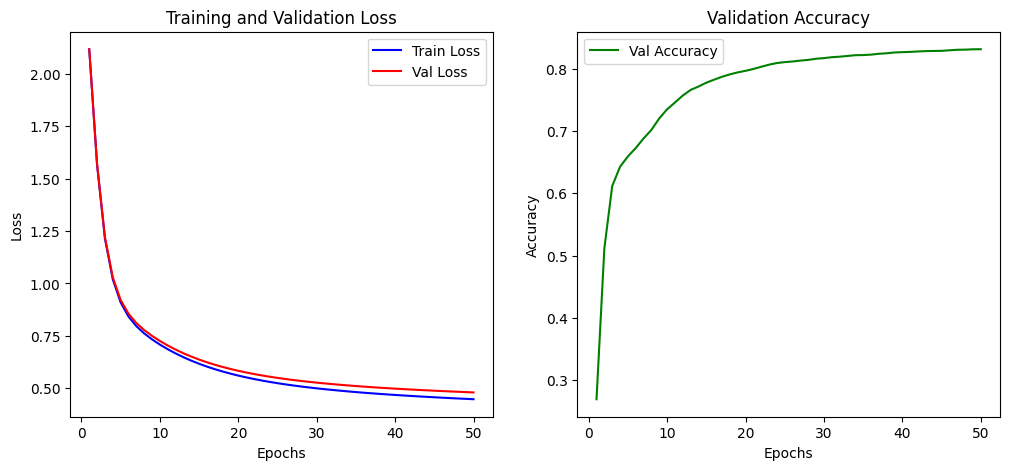

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import utils.mnist_reader as mnist_reader

# 加载Fashion-MNIST数据集
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# 数据预处理
X_train = X_train.T / 255.0
X_test = X_test.T / 255.0

# 将标签转换为独热编码
def one_hot_encoding(labels, num_classes):
    num_examples = labels.shape[0]
    one_hot_labels = np.zeros((num_classes, num_examples))
    for i in range(num_examples):
        one_hot_labels[labels[i], i] = 1
    return one_hot_labels

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

def train_model(model, X_train, Y_train, X_val, Y_val, num_epochs, learning_rate, reg_strength, batch_size):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        for i in range(0, X_train.shape[1], batch_size):
            # 获取一个小批量样本
            X_batch = X_train[:, i:i+batch_size]
            Y_batch = Y_train[:, i:i+batch_size]
            
            # 前向传播和反向传播
            model.backward(X_batch, Y_batch, learning_rate, reg_strength)
        
        # 计算训练集损失
        train_loss = compute_loss(model, X_train, Y_train, reg_strength)
        train_loss_history.append(train_loss)
        
        # 计算验证集损失和准确率
        val_loss = compute_loss(model, X_val, Y_val, reg_strength)
        val_loss_history.append(val_loss)
        val_acc = compute_accuracy(model, X_val, Y_val)
        val_acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2%}')
    
    return train_loss_history, val_loss_history, val_acc_history

# 可视化训练过程中的损失和准确率变化
def plot_training_history(train_loss_history, val_loss_history, val_acc_history):
    epochs = range(1, len(train_loss_history) + 1)

    # 绘制损失曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss_history, label='Val Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc_history, label='Val Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 计算损失函数
def compute_loss(model, X, Y, reg_strength):
    m = X.shape[1]
    A2 = model.forward(X)
    cross_entropy_loss = -1/m * np.sum(Y * np.log(A2 + 1e-8))  # 添加微小数以避免log(0)错误
    regularization_loss = reg_strength/(2*m) * (np.sum(np.square(model.params['W1'])) + np.sum(np.square(model.params['W2'])))
    total_loss = cross_entropy_loss + regularization_loss
    return total_loss

# 计算准确率函数
def compute_accuracy(model, X, Y):
    A2 = model.forward(X)
    predictions = np.argmax(A2, axis=0)
    labels = np.argmax(Y, axis=0)
    accuracy = np.mean(predictions == labels)
    return accuracy

# 测试部分
def test_model(model, X_test, Y_test):
    test_accuracy = compute_accuracy(model, X_test, Y_test)
    print(f"测试集准确率（Accuracy）: {test_accuracy:.2%}")
#模型权重保存
def save_model_weights(model, filepath):
    weights = model.params
    np.save(filepath, weights)

# 定义超参数
input_size = 784  # 输入层大小（图像大小为28x28）
output_size = 10  # 输出层大小（类别数）
hidden_size = 128  # 隐藏层大小
activation = 'relu'  # 激活函数类型
learning_rate = 0.001  # 学习率
reg_strength = 0.01  # 正则化强度
num_epochs = 50  # 迭代次数
batch_size = 32 # 批量大小

# 初始化模型
model = NeuralNetwork(input_size, hidden_size, output_size, activation)


# 训练模型
train_loss_history, val_loss_history, val_acc_history = train_model(model, X_train, y_train, X_test, y_test, num_epochs, learning_rate, reg_strength, batch_size)
plot_training_history(train_loss_history, val_loss_history, val_acc_history)




In [60]:
def save_model_weights(model, filepath):
    weights = model.params
    np.save(filepath, weights)
save_model_weights(model, "E:/24年春季学期/神经网络/fashion-mnist-master/model_weights.npy")

# 三、测试

In [52]:
# 测试模型
test_model(model, X_test, y_test)

测试集准确率（Accuracy）: 83.14%


# 四、参数查找

Epoch 1/10, Train Loss: 2.2888, Val Loss: 2.2889, Val Accuracy: 34.13%
Epoch 2/10, Train Loss: 2.2322, Val Loss: 2.2325, Val Accuracy: 39.24%
Epoch 3/10, Train Loss: 2.0515, Val Loss: 2.0527, Val Accuracy: 40.30%
Epoch 4/10, Train Loss: 1.7656, Val Loss: 1.7684, Val Accuracy: 41.48%
Epoch 5/10, Train Loss: 1.5307, Val Loss: 1.5351, Val Accuracy: 44.96%
Epoch 6/10, Train Loss: 1.3675, Val Loss: 1.3735, Val Accuracy: 54.30%
Epoch 7/10, Train Loss: 1.2446, Val Loss: 1.2521, Val Accuracy: 57.33%
Epoch 8/10, Train Loss: 1.1457, Val Loss: 1.1545, Val Accuracy: 59.62%
Epoch 9/10, Train Loss: 1.0660, Val Loss: 1.0760, Val Accuracy: 61.71%
Epoch 10/10, Train Loss: 1.0025, Val Loss: 1.0134, Val Accuracy: 63.02%
Epoch 1/10, Train Loss: 2.2902, Val Loss: 2.2902, Val Accuracy: 21.43%
Epoch 2/10, Train Loss: 2.2353, Val Loss: 2.2354, Val Accuracy: 20.18%
Epoch 3/10, Train Loss: 2.0608, Val Loss: 2.0613, Val Accuracy: 21.29%
Epoch 4/10, Train Loss: 1.7863, Val Loss: 1.7879, Val Accuracy: 41.05%
Epoch

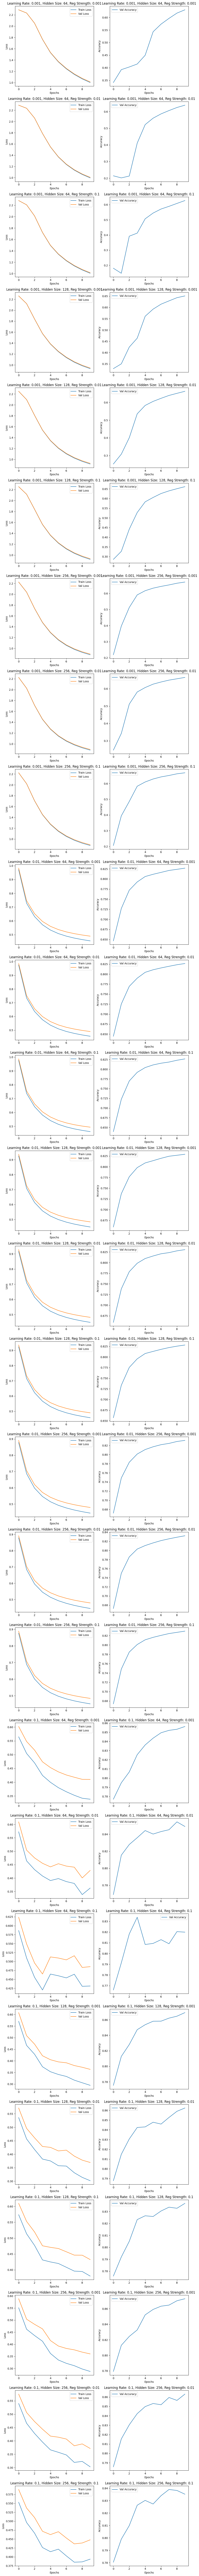

In [53]:
def parameter_search(X_train, y_train, X_val, y_val, num_classes, input_size=784, output_size=10, activation='relu', num_epochs=10, batch_size=64):
    learning_rates = [0.001, 0.01, 0.1]
    hidden_sizes = [64, 128, 256]
    reg_strengths = [0.001, 0.01, 0.1]
    
    best_val_accuracy = 0
    best_params = {}
    history = []

    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for reg_strength in reg_strengths:
                model = NeuralNetwork(input_size, hidden_size, output_size, activation)
                train_loss_history, val_loss_history, val_acc_history = train_model(model, X_train, y_train, X_val, y_val, num_epochs, lr, reg_strength, batch_size)
                val_accuracy = val_acc_history[-1]

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_params = {'learning_rate': lr, 'hidden_size': hidden_size, 'reg_strength': reg_strength}
                
                history.append({
                    'learning_rate': lr,
                    'hidden_size': hidden_size,
                    'reg_strength': reg_strength,
                    'val_accuracy': val_accuracy,
                    'train_loss_history': train_loss_history,
                    'val_loss_history': val_loss_history,
                    'val_acc_history': val_acc_history
                })

    return best_params, history

def visualize_training(history):
    num_plots = len(history)
    fig, axs = plt.subplots(num_plots, 3, figsize=(15, num_plots * 5))

    for i, params_history in enumerate(history):
        learning_rate = params_history['learning_rate']
        hidden_size = params_history['hidden_size']
        reg_strength = params_history['reg_strength']

        train_loss_history = params_history['train_loss_history']
        val_loss_history = params_history['val_loss_history']
        val_acc_history = params_history['val_acc_history']

        axs[i, 0].plot(train_loss_history, label='Train Loss')
        axs[i, 0].plot(val_loss_history, label='Val Loss')
        axs[i, 0].set_title(f'Learning Rate: {learning_rate}, Hidden Size: {hidden_size}, Reg Strength: {reg_strength}')
        axs[i, 0].set_xlabel('Epochs')
        axs[i, 0].set_ylabel('Loss')
        axs[i, 0].legend()

        axs[i, 1].plot(val_acc_history, label='Val Accuracy')
        axs[i, 1].set_title(f'Learning Rate: {learning_rate}, Hidden Size: {hidden_size}, Reg Strength: {reg_strength}')
        axs[i, 1].set_xlabel('Epochs')
        axs[i, 1].set_ylabel('Accuracy')
        axs[i, 1].legend()

        axs[i, 2].set_visible(False)

    plt.tight_layout()
    plt.show()

best_params, history = parameter_search(X_train, y_train, X_test, y_test, num_classes)
visualize_training(history)
